Weekly trading strategy based on Gaussian HMM trained on VIX.

In [1]:
import numpy as np
import pandas as pd
import hmmlearn.hmm as hmm
import matplotlib.pyplot as plt
import quantstats as qs
import yfinance as yf

In [2]:
def load_weekly_data(ticker):
    df = yf.download(ticker, interval = '1wk', period = 'max')[['Open','High','Low','Close','Volume','Adj Close']].reset_index()
    df['Ratio'] = df['Adj Close'] / df['Close']
    df['Open'] = df['Open'] * df['Ratio']
    df['High'] = df['High'] * df['Ratio']
    df['Low'] = df['Low'] * df['Ratio']
    df['Close'] = df['Close'] * df['Ratio']
    df = df.drop(['Ratio', 'Adj Close'], axis = 1)
    df.columns = ['date','open','high','low','close','volume']
    df = df.set_index(['date'])
    df = df.dropna()
    
    return df

def hmmModel(train, test, states):
    train_vals = train.values
    train_vals =  np.expand_dims(train_vals, 1)
    train_vals = np.reshape(train_vals,[len(train_vals),1])
    test_vals = test.values
    test_vals =  np.expand_dims(test_vals, 1)
    test_vals = np.reshape(test_vals,[len(test_vals),1])
    
    model = hmm.GaussianHMM(n_components=states, n_iter=1000)
    model = model.fit(train_vals)
    
    hiddenState = model.predict(test_vals)
    postProb = np.array(model.predict_proba(test_vals))
    
    states = pd.DataFrame(hiddenState, index = test.index);states.names = 'states'
    probs = pd.DataFrame(postProb, index = test.index);probs.columns = ['state_1', 'state_2', 'state_3']
    df = pd.concat([states, probs], axis = 1)
    
    return pd.concat([states, probs], axis = 1), model.means_

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


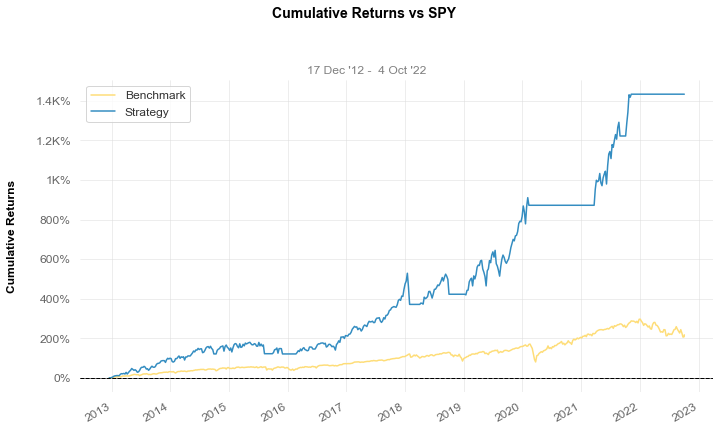

strategy sharpe: 1.216


In [3]:
data = load_weekly_data('^VIX').close
n = np.floor(data.shape[0] * 0.7).astype(int)
results, _ = hmmModel(data.iloc[:n], data.iloc[n:], 3)

for i in range(_.shape[0]):
    if _[i] == np.min(_):
        v = i
    else:
        pass

df = results.copy()
spy = load_weekly_data('SPXL').loc[df.index].close
df = pd.concat([spy.shift(-1).pct_change().dropna(),df], axis = 1).dropna()
df.rename(columns = {'close':'spy'}, inplace = True)

strat = pd.DataFrame(np.where(df[0] == v, df.spy, 0),index = df.index)[0]

qs.plots.returns(strat, 'SPY')
print(f'strategy sharpe: {np.round(qs.stats.sharpe(strat, periods = 52),3)}')